
 Data successfully merged!


 Generating Correlation Heatmap...



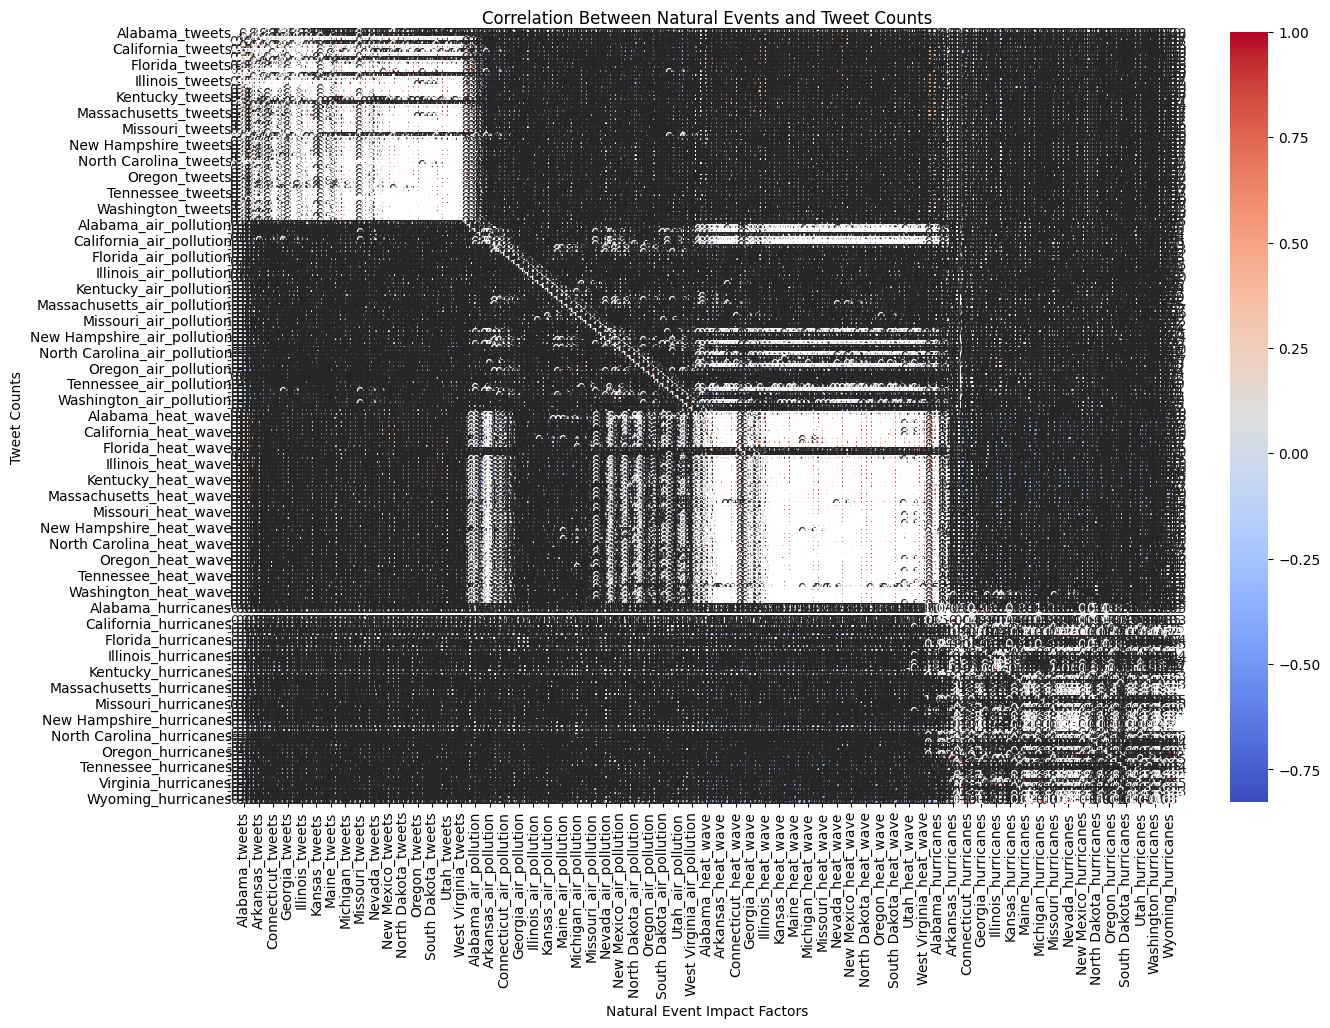


 Running Regression Analysis for California...


Regression Results for California
                            OLS Regression Results                            
Dep. Variable:      California_tweets   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     22.61
Date:                Fri, 04 Jul 2025   Prob (F-statistic):           1.95e-13
Time:                        17:22:38   Log-Likelihood:                -2536.8
No. Observations:                 365   AIC:                             5082.
Df Residuals:                     361   BIC:                             5097.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

c:\Users\taeyong0209\anaconda3\envs\cc_project_2\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [3]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# ====== STEP 1: Load the Datasets ======
file_paths = {
    "air_pollution": r"D:\TY\기특대 논문\Nature Climate Change\Code\Regression\data\Air_pollution_impact_factors_US.xlsx",
    "floods": r"D:\TY\기특대 논문\Nature Climate Change\Code\Regression\data\Floods_impact_factors_US.xlsx",
    "heat_wave": r"D:\TY\기특대 논문\Nature Climate Change\Code\Regression\data\Heat_wave_impact_factors_US.xlsx",
    "hurricanes": r"D:\TY\기특대 논문\Nature Climate Change\Code\Regression\data\Hurricanes_impact_factors_US.xlsx",
    "tweets": r"D:\TY\기특대 논문\Nature Climate Change\Code\Regression\data\Tweet_counts_All_2019_US.xlsx",
}

# Read each Excel file
dataframes = {key: pd.ExcelFile(path) for key, path in file_paths.items()}

# Load the first sheet from each file
df_air_pollution = dataframes["air_pollution"].parse("Sheet1")
df_floods = dataframes["floods"].parse("Sheet1")
df_heat_wave = dataframes["heat_wave"].parse("Sheet1")
df_hurricanes = dataframes["hurricanes"].parse("Sheet1")
df_tweets = dataframes["tweets"].parse("Sheet1")

# Convert 'Date' columns to datetime format
for df in [df_air_pollution, df_floods, df_heat_wave, df_hurricanes, df_tweets]:
    df["Date"] = pd.to_datetime(df["Date"])


# ====== STEP 2: Merge All Datasets on 'Date' ======
merged_df = df_tweets.merge(df_air_pollution, on="Date", suffixes=("_tweets", "_air_pollution"))
merged_df = merged_df.merge(df_floods, on="Date")
merged_df = merged_df.merge(df_heat_wave, on="Date", suffixes=("", "_heat_wave"))
merged_df = merged_df.merge(df_hurricanes, on="Date", suffixes=("", "_hurricanes"))

# Drop duplicate columns
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Handle missing values (fill NaNs with 0 assuming no impact)
merged_df.fillna(0, inplace=True)

print("\n Data successfully merged!\n")


# ====== STEP 3: Correlation Analysis ======
def correlation_analysis():
    print("\n Generating Correlation Heatmap...\n")

    # Select tweet counts and event factors for correlation
    tweet_cols = [col for col in merged_df.columns if "tweets" in col]
    event_cols = [col for col in merged_df.columns if any(x in col for x in ["air_pollution", "floods", "heat_wave", "hurricanes"])]

    # Compute correlation matrix
    corr_selected = merged_df[tweet_cols + event_cols].corr()

    # Plot heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_selected, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Between Natural Events and Tweet Counts")
    plt.xlabel("Natural Event Impact Factors")
    plt.ylabel("Tweet Counts")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

correlation_analysis()


# ====== STEP 4: Multiple Linear Regression ======
def run_regression(state):
    try:
        print(f"\n Running Regression Analysis for {state}...\n")

        # Correct the column names (floods column does not have '_floods' suffix)
        X = merged_df[[
            f"{state}_air_pollution",
            state,  # Floods column appears without suffix
            f"{state}_heat_wave",
            f"{state}_hurricanes"
        ]]
        X = X.rename(columns={state: f"{state}_floods"})  # Rename for clarity

        # Dependent variable (tweet counts)
        y = merged_df[f"{state}_tweets"]

        # Add constant term
        X = sm.add_constant(X)

        # Fit multiple linear regression model
        model = sm.OLS(y, X).fit()

        # Print regression results
        print(f"\nRegression Results for {state}")
        print(model.summary())

    except KeyError as e:
        print(f"Error: Column not found - {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")



# ====== STEP 5: Run Analysis for Multiple States ======
states_to_analyze = ["California", "Florida", "Texas", "New York"]

for state in states_to_analyze:
    run_regression(state)


# ====== STEP 6: Automatically Extract All State Names ======
states_to_analyze = [col.replace("_tweets", "") for col in merged_df.columns if "_tweets" in col]
states_to_analyze, len(states_to_analyze)


# ====== STEP 7: Multiple Linear Regression & Store Results ======
regression_results_all_states = []

# Run regression for each state
for state in states_to_analyze:
    try:
        print(f"\n Running Regression for {state}...")

        # Define independent variables (event factors)
        X = merged_df[[f"{state}_air_pollution", state, f"{state}_heat_wave", f"{state}_hurricanes"]]
        X = X.rename(columns={state: f"{state}_floods"})  # Rename for clarity

        # Define dependent variable (tweet counts)
        y = merged_df[f"{state}_tweets"]

        # Add constant term
        X = sm.add_constant(X)

        # Fit multiple linear regression model
        model = sm.OLS(y, X).fit()

        # Store results in dictionary
        results_dict = {
            "State": state,
            "R-squared": model.rsquared,
            "Adj. R-squared": model.rsquared_adj,
            "F-statistic (p-value)": model.f_pvalue,
            "Air Pollution Coeff": model.params.get(f"{state}_air_pollution", "N/A"),
            "Air Pollution p-value": model.pvalues.get(f"{state}_air_pollution", "N/A"),
            "Floods Coeff": model.params.get(f"{state}_floods", "N/A"),
            "Floods p-value": model.pvalues.get(f"{state}_floods", "N/A"),
            "Heat Wave Coeff": model.params.get(f"{state}_heat_wave", "N/A"),
            "Heat Wave p-value": model.pvalues.get(f"{state}_heat_wave", "N/A"),
            "Hurricanes Coeff": model.params.get(f"{state}_hurricanes", "N/A"),
            "Hurricanes p-value": model.pvalues.get(f"{state}_hurricanes", "N/A")
        }

        regression_results_all_states.append(results_dict)

    except KeyError as e:
        print(f"Skipping {state} due to missing data: {e}")
    except Exception as e:
        print(f"Unexpected error for {state}: {e}")

# Convert results to DataFrame
df_regression_results_all_states = pd.DataFrame(regression_results_all_states)


# ====== STEP 8: Save Results to Excel ======
df_regression_results_all_states.to_excel(r"D:\TY\기특대 논문\Nature Climate Change\Code\Regression\result\regression_results_norm_US.xlsx", index=False)

print("\n Regression analysis completed! Results saved as 'regression_results_all_states_norm.xlsx'.\n")

# Print the final results table
print(df_regression_results_all_states)